### 一.变分EM算法
在介绍LDA的变分EM实现之前，首先我们要弄懂什么是变分EM，变分推断我们在之前提过，EM算法也在之前提过，可是将它俩凑一起似乎就不认识了呢....，这里还请大家回去看一下15章的这俩小结[《变分推断的原理推导》](https://nbviewer.jupyter.org/github/zhulei227/ML_Notes/blob/master/notebooks/15_01_VI_%E5%8F%98%E5%88%86%E6%8E%A8%E6%96%AD%E7%9A%84%E5%8E%9F%E7%90%86%E6%8E%A8%E5%AF%BC.ipynb)以及[《变分推断与EM的关系》](https://nbviewer.jupyter.org/github/zhulei227/ML_Notes/blob/master/notebooks/15_02_VI_%E5%8F%98%E5%88%86%E6%8E%A8%E6%96%AD%E4%B8%8EEM%E7%9A%84%E5%85%B3%E7%B3%BB.ipynb) 看完之后，也许就能猜出变分EM是要怎么做了，下面我再做一个简单的说明

![avatar](./source/15_EM中三者间的关系.png)

如上图，我们知道带参数的对数似然函数$ln\ p(X\mid\theta)$，可以拆解为一个证据下界ELBO函数$L(q,\theta)$和一个KL距离$KL(q||p)$，这里的$q$即是我们的变分分布，为了使它更加简单通常对其做一个平均场假设，即各个隐变量（组）之间是独立的：   

$$
q(z)=q(z_1)q(z_2)\cdots q(z_n)
$$  

而$p$则是复杂的后验概率分布：   

$$
p(z)=p(z\mid X,\theta)
$$  

好的，在此基础上，我们来看看变分推断和EM分别要做怎么样的一件事：   

#### 变分推断
变分推断要做的事情是让简单的变分分布去近似复杂的后验分布：   

$$
q(z)\rightarrow p(z)
$$  

它并不关心$\theta$，将其视作一个常数处理，通过最大化ELBO函数来使得$KL(q||p)$最小化，从而使$q$与$p$近似，即它要做的是如下的优化问题：   

$$
q^*=arg\max_{q}L(q,\theta)
$$  

#### EM
而EM算法的初衷是要通过优化$\theta$使得对数似然函数极大化，它令：   

$$
q(z)=p(z\mid X,\theta^{old})
$$  

这时$KL(q||p)=0$，所以有：   

$$
L(q,\theta)=ln\ p(X\mid \theta)
$$  

这时，对ELBO函数极大化等价于对对数似然函数极大化，从而得到最优解：   

$$
\theta=arg\max_{\theta}L(q\mid\theta),q(z)=p(z\mid X,\theta^{old})
$$  

显然，使用EM算法的前提是后验概率分布$p(z\mid X,\theta)$的形式比较方便求解，如果它很复杂呢？那变分EM就诞生了...

#### 变分EM

变分EM不改EM的初衷，即要使得对数似然函数$ln\ p(X\mid \theta)$极大化，同时对于$p(z\mid X,\theta)$利用一个简单的变分分布$q(z)$去近似，所以变分EM算法的优化变量包括两个：$q$和$\theta$   

$$
q^*,\theta^*=arg\max_{q,\theta}L(q,\theta)
$$   
而优化过程通常采用坐标轮换法，即：   

（1）E步：固定$\theta$，求$L(q,\theta)$对$q$的最大化；   
（2）M步：固定$q$，求$L(q,\theta)$对$\theta$的最大化；  

如果对变分EM没问题了，接下来就要考虑利用变分EM去求LDA模型的什么分布勒？回想一下上一节的Gibbs采样，我们去求相同的分布不就可以了，但LDA的变分EM求解还做了进一步的简化

### 二.ELBO推导
变分EM对LDA模型做了如下简化
![avatar](./source/16_变分EM的LDA模型.png)
省略了超参数$\beta$，其中$\alpha,\varphi$为模型参数，$\theta,z$是隐变量，$w$是可观测变量，为了简便，一次只考虑一个文本，记作$w=(w_1,w_2,...,w_N)$，对应的主题序列$z=(z_1,z_2,...,z_N)$，对应的话题分布为$\theta$，所以其联合概率分布可以表示为：   

$$
p(\theta,z,w\mid\alpha,\varphi)=p(\theta\mid\alpha)\prod_{n=1}^Np(z_n\mid\theta)p(w_n\mid z_n,\varphi)
$$  

所以，我们需要去近似后验概率$p(\theta,z\mid w,\alpha,\varphi)$，可以定义变分分布为：   

$$
q(\theta,z\mid\gamma,\eta)=q(\theta\mid\gamma)\prod_{n=1}^Nq(z_n\mid\eta_n)
$$  

其中，$\gamma=(\gamma_1,\gamma_2,...,\gamma_K)$是狄利克雷分布参数，$\eta=(\eta_1,\eta_2,...,\eta_n)$是多项分布参数，变量$\theta$和$z$的各个分量都是条件独立的，它的盘子图如下：   
![avatar](./source/16_变分EM的变分分布.png)  

所以，其证据下界ELBO可以写作：   

$$
L(\gamma,\eta,\alpha,\varphi)=E_q[ln\ p(\theta,z,w\mid\alpha,\varphi)]-E_q[ln\ q(\theta,z\mid\gamma,\eta)]
$$  

其中数学期望是对分布$q(\theta,z\mid\gamma,\eta)$定义的，为了方便简写为$E_q[\cdot]$，$\gamma$和$\eta$是变分分布的参数，$\alpha$和$\varphi$是LDA模型的参数

### 三.参数求解

所以接下来，就是固定$\gamma,\eta$，求$L(\gamma,\eta,\alpha,\varphi)$对$\alpha,\varphi$的极大化，然后固定$\alpha,\varphi$，求$L(\gamma,\eta,\alpha,\varphi)$对$\gamma,\eta$的极大化，持续下去直到收敛...推导过程的公式不想码了，哈哈哈，自己看《统计学习方法》吧，下面就直接写参数求解的算法了，并对必要的符号做说明

#### 算法一：对变分参数$\gamma,\eta$估计
>初始化：对所有的$k$和$n$，$\eta_{nk}^{(0)}=1/K$（$k$表示主题，$n$表示当前文本的第$n$个位置，$K$表示总主题数）  

>初始化：对所有的$k$，$\gamma_k=\alpha_k+N/K$（$k$表示主题，$K$表示总主题数，$N$表示当前文本的总字数）  

>重复
>>对$n=1:N$
>>>对$k=1:K$
>>>>$\eta_{nk}^{(t+1)}=\varphi_{kv}exp\left[\Psi(\gamma_k^{(t)})-\Psi(\sum_{l=1}^K\gamma_l^{(t)})\right]$

>>>规范化$\eta_{nk}^{(t+1)}$使其和为1

>>$\gamma^{(t+1)}=\alpha+\sum_{n=1}^N\eta_n^{(t+1)}$

>直到收敛

这里，$\Psi(\cdot)$为digamma函数，即：   

$$
\Psi(x)=\frac{d\ ln\ \Gamma(x)}{dx}
$$
$\Psi(\cdot)$可以使用`scipy.special.digamma`直接求解，哈哈哈~

#### 算法二：对LDA参数$\alpha,\varphi$估计
基于上面的$\gamma,\eta$可以写出$\alpha,\varphi$的计算公式,...省略了推导过程....

$$
\varphi_{kv}=\sum_{m=1}^M\sum_{n=1}^{N_m}\eta_{mnk}w_{mn}^v
$$  

其中，$\eta_{mnk}$表示第$m$个文本的第$n$个单词属于第$k$个话题的概率，$w_{mn}^v$在第$m$个文本的第$n$个单词是单词集合的第$v$个单词时取值为1，否则为0，而$\alpha$的更新为  

$$
\alpha_{new}=\alpha_{old}-H(\alpha_{old})^{-1}g(\alpha_{old})
$$  

其中，$g(\cdot)$表示其梯度，计算公式为：   

$$
\frac{\partial L}{\partial \alpha_k}=M\left[\Psi(\sum_{l=1}^K\alpha_l)-\Psi(\alpha_k) \right]-\sum_{m=1}^M\left[\Psi(\gamma_{mk})-\Psi(\sum_{l=1}^K\gamma_{ml})\right]
$$  

而$H$表示Hessian矩阵，计算公式如下：   

$$
\frac{\partial^2 L}{\partial\alpha_k\partial\alpha_l}=M\left[\Psi'\left(\sum_{l=1}^K\alpha_l\right)-\delta(k,l)\Psi'(\alpha_k)\right]
$$  

其中，$\delta(k,l)$是delta函数

所以，对**算法一**和**算法二**交替迭代，直到收敛即是我们想要的结果，另外对于$\alpha$的更新，为了方便，笔者将Hessian矩阵的逆$H^{-1}$这一部分替换为学习率进行计算，即将二阶的牛顿法替换为一阶的梯度下降法（其实是能力有限，不知道$\psi'$和$delta$如何计算...哈哈哈）

In [23]:
"""
隐狄利克雷分布的代码实现，包括Gibbs采样和变分EM算法，代码封装在ml_models.latent_dirichlet_allocation
"""
import numpy as np
from scipy.special import digamma


class LDA(object):
    def __init__(self, alpha=None, beta=None, K=10, tol=1e-3, epochs=100, method="gibbs", lr=1e-5):
        """
        :param alpha: 主题分布的共轭狄利克雷分布的超参数
        :param beta: 单词分布的共轭狄利克雷分布的超参数
        :param K: 主题数量
        :param tol:容忍度，允许tol的隐变量差异
        :param epochs:最大迭代次数
        :param method:优化方法，默认gibbs,另外还有变分EM,vi_em
        :param lr:学习率,对vi_em生效
        """
        self.alpha = alpha
        self.beta = beta
        self.K = K
        self.tol = tol
        self.epochs = epochs
        self.method = method
        self.lr = lr
        self.phi = None  # 主题-单词矩阵

    def _init_params(self, W):
        """
        初始化参数
        :param W:
        :return:
        """
        M = len(W)  # 文本数
        V = 0  # 词典大小
        I = 0  # 单词总数
        for w in W:
            V = max(V, max(w))
            I += len(w)
        V += 1  # 包括0
        # 文本话题计数
        N_M_K = np.zeros(shape=(M, self.K))
        N_M = np.zeros(M)
        # 话题单词计数
        N_K_V = np.zeros(shape=(self.K, V))
        N_K = np.zeros(self.K)
        # 初始化隐状态,计数矩阵
        Z = []  # 隐状态，与W一一对应
        p = [1 / self.K] * self.K
        hidden_status = list(range(self.K))
        for m, w in enumerate(W):
            z = np.random.choice(hidden_status, len(w), replace=True, p=p).tolist()
            Z.append(z)
            for n, k in enumerate(z):
                v = w[n]
                N_M_K[m][k] += 1
                N_M[m] += 1
                N_K_V[k][v] += 1
                N_K[k] += 1
        # 初始化alpha和beta
        if self.alpha is None:
            self.alpha = np.ones(self.K)
        if self.beta is None:
            self.beta = np.ones(V)
        return Z, N_M_K, N_M, N_K_V, N_K, M, V, I, hidden_status

    def _fit_gibbs(self, W):
        """
        :param W: 文本集合[[...],[...]]
        :return:
        """
        Z, N_M_K, N_M, N_K_V, N_K, M, V, I, hidden_status = self._init_params(W)
        for _ in range(self.epochs):
            error_num = 0
            for m, w in enumerate(W):
                z = Z[m]
                for n, topic in enumerate(z):
                    word = w[n]
                    N_M_K[m][topic] -= 1
                    N_M[m] -= 1
                    N_K_V[topic][word] -= 1
                    N_K[topic] -= 1
                    # 采样一个新k
                    p = []  # 更新多项分布
                    for k_ in range(self.K):
                        p_ = (N_K_V[k_][word] + self.beta[word]) * (N_M_K[m][k_] + self.alpha[topic]) / (
                            (N_K[k_] + np.sum(self.beta)) * (N_M[m] + np.sum(self.alpha)))
                        p.append(p_)
                    ps = np.sum(p)
                    p = [p_ / ps for p_ in p]
                    topic_new = np.random.choice(hidden_status, 1, p=p)[0]
                    if topic_new != topic:
                        error_num += 1
                    Z[m][n] = topic_new
                    N_M_K[m][topic_new] += 1
                    N_M[m] += 1
                    N_K_V[topic_new][word] += 1
                    N_K[topic_new] += 1
            if error_num / I < self.tol:
                break

        # 计算参数phi
        self.phi = N_K_V / np.sum(N_K_V, axis=1, keepdims=True)

    def _fit_vi_em(self, W):
        """
        分为两部分，迭代计算：
        （1）给定lda参数，更新变分参数
        （2）给定变分参数，更新lda参数
        :param W:
        :return:
        """
        V = 0  # 词典大小
        for w in W:
            V = max(V, max(w))
        V += 1
        M = len(W)

        # 给定lda参数，更新变分参数
        def update_vi_params(alpha, phi):
            eta = []
            gamma = []
            for w in W:
                N = len(w)
                eta_old = np.ones(shape=(N, self.K)) * (1 / self.K)
                gamma_old = alpha + N / self.K
                eta_new = np.zeros_like(eta_old)
                for _ in range(self.epochs):
                    for n in range(0, N):
                        for k in range(0, self.K):
                            eta_new[n, k] = phi[k, w[n]] * np.exp(digamma(gamma_old[k]) - digamma(np.sum(gamma_old)))
                    eta_new = eta_new / np.sum(eta_new, axis=1, keepdims=True)
                    gamma_new = alpha + np.sum(eta_new, axis=0)
                    # 每个元素的平均变化小于指定的tolerance则停止训练
                    if (np.sum(np.abs(gamma_new - gamma_old)) + np.sum(np.abs((eta_new - eta_old)))) / (
                                (N + 1) * self.K) < self.tol:
                        break
                    else:
                        eta_old = eta_new.copy()
                        gamma_old = gamma_new.copy()
                eta.append(eta_new)
                gamma.append(gamma_new)
            return eta, gamma

        # 给定变分参数，更新lda参数
        def update_lda_params(eta, gamma, alpha_old):
            # 更新phi
            phi = np.zeros(shape=(self.K, V))
            for m, w in enumerate(W):
                for n, word in enumerate(w):
                    for k in range(0, self.K):
                        for v in range(0, V):
                            phi[k, v] += eta[m][n, k] * (word == v)
            # 更新alpha
            d_alpha = []
            for k, alpha_ in enumerate(alpha_old):
                tmp = M * (digamma(np.sum(alpha_old)) - digamma(alpha_))
                for m in range(M):
                    tmp -= (digamma(gamma[m][k]) - digamma(np.sum(gamma[m])))
                d_alpha.append(tmp)
            # 使用梯度下降算法更新模型的参数，而不是拟牛顿法或者是牛顿法
            alpha_new = alpha_old - self.lr * np.asarray(d_alpha)
            alpha_new = np.where(alpha_new < 0.0, 0.0, alpha_new)
            alpha_new = alpha_new / (1e-9 + np.sum(alpha_new))
            phi = phi / (np.sum(phi, axis=1, keepdims=True) + 1e-9)
            return alpha_new, phi

        # 初始化alpha和phi
        alpha_old = np.random.random(self.K)
        phi_old = np.random.random(size=(self.K, V))
        phi_old = phi_old / np.sum(phi_old, axis=1, keepdims=True)
        for _ in range(self.epochs):
            # 对分布q进行优化
            eta, gamma = update_vi_params(alpha_old, phi_old)
            # 对模型参数进行优化
            alpha_new, phi_new = update_lda_params(eta, gamma, alpha_old)
            if (np.sum(np.abs(alpha_new - alpha_old)) + np.sum(np.abs((phi_new - phi_old)))) / (
                        (V + 1) * self.K) < self.tol:
                break
            else:
                alpha_old = alpha_new.copy()
                phi_old = phi_new.copy()
        self.phi = phi_new
        self.alpha = alpha_new

    def fit(self, W):
        if self.method == "gibbs":
            self._fit_gibbs(W)
        else:
            self._fit_vi_em(W)

    def transform(self, W):
        rst = []
        for w in W:
            tmp = np.zeros(shape=self.K)
            for v in w:
                try:
                    v_ = self.phi[:, v]
                except:
                    v_ = np.zeros(shape=self.K)
                tmp += v_
            if np.sum(tmp) > 0:
                tmp = tmp / np.sum(tmp)
            rst.append(tmp)
        return np.asarray(rst)

### 六.测试

In [24]:
docs=[
    ["有","微信","红包","的","软件"],
    ["微信","支付","不行","的"],
    ["我们","需要","稳定的","微信","支付","接口"],
    ["申请","公众号","认证"],
    ["这个","还有","几天","放","垃圾","流量"],
    ["可以","提供","聚合","支付","系统"]
]

In [25]:
word2id={}
idx=0
W=[]
for doc in docs:
    tmp=[]
    for word in doc:
        if word in word2id:
            tmp.append(word2id[word])
        else:
            word2id[word]=idx
            idx+=1
            tmp.append(word2id[word])
    W.append(tmp)
W

[[0, 1, 2, 3, 4],
 [1, 5, 6, 3],
 [7, 8, 9, 1, 5, 10],
 [11, 12, 13],
 [14, 15, 16, 17, 18, 19],
 [20, 21, 22, 5, 23]]

In [26]:
lda=LDA(epochs=1000,method="vi_em")
lda.fit(W)
print(lda.alpha)
trans=lda.transform(W)

[0.215 0.    0.039 0.175 0.17  0.001 0.23  0.093 0.    0.078]


In [27]:
#第二句和第三句应该比较近似，因为它们都含有“微信”，“支付”
trans[1].dot(trans[2])

0.253299835385148

In [28]:
#而第二句和第四句的相似度显然不如第二句和第三句
trans[1].dot(trans[3])

5.244443238229108e-05

In [29]:
#当然第二句和第五句的差距也有些大
trans[1].dot(trans[4])

0.060624503257150616

In [30]:
#而第一句和第二句都含有“微信”，所以相似度会比第四、五句高，但这里比第三句高...
trans[1].dot(trans[0])

0.22025876656079196

从结果来看还基本能接受的，还有训练速度会比gibbs快不少，另外代码效率还有不少的优化空间~~~

In [34]:
import numpy as np
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

if __name__ == "__main__":
    np.set_printoptions(precision=3, suppress=True)

    example = [["guide", "investing", "market", "stock"],
               ["dummies", "investing"],
               ["book", "investing", "market", "stock"],
               ["book", "investing", "value"],
               ["investing", "value"],
               ["dads", "guide", "investing", "rich", "rich"],
               ["estate", "investing", "real"],
               ["dummies", "investing", "stock"],
               ["dads", "estate", "investing", "real", "rich"]]

    # 将文档转换为词频向量：(文本集合中的第m个文本,单词集合中的第v个单词) = 第v个单词在第m个文本中的出现频数
    count_vector = CountVectorizer()
    tf = count_vector.fit_transform([" ".join(doc) for doc in example])

    # 训练LDA主题模型：n_components = 话题数量
    lda = LatentDirichletAllocation(n_components=3,  # 话题个数K
                                    learning_method="batch",  # 学习方法：batch=变分推断EM算法(默认)；online=在线变分推断EM算法
                                    random_state=0)
    doc_topic_distr = lda.fit_transform(tf)

    print("【文本-话题计数矩阵】doc_topic_distr[i] = 第i个文本的话题分布")
    print(doc_topic_distr)
    # [[0.07 0.86 0.07]
    #  [0.12 0.76 0.12]
    #  [0.07 0.86 0.07]
    #  [0.82 0.09 0.09]
    #  [0.76 0.12 0.12]
    #  [0.88 0.06 0.06]
    #  [0.09 0.09 0.82]
    #  [0.09 0.83 0.09]
    #  [0.07 0.06 0.88]]

    print("【单词-话题非规范化概率矩阵】components_[i][j] = 第i个话题生成第j个单词的未规范化的概率")
    print(lda.components_)
    # [[1.33 1.33 0.33 0.33 1.34 3.33 0.33 0.33 2.35 0.33 2.33]
    #  [1.33 0.33 2.33 0.33 1.32 4.33 2.33 0.33 0.33 3.33 0.33]
    #  [0.34 1.34 0.33 2.33 0.34 2.34 0.33 2.33 1.32 0.33 0.33]]

    print("【单词-话题概率矩阵】components_[i][j] = 第i个话题生成第j个单词的概率")
    print(lda.components_ / lda.components_.sum(axis=1,keepdims=True))
    # [[0.1  0.1  0.02 0.02 0.1  0.24 0.02 0.02 0.17 0.02 0.17]
    #  [0.08 0.02 0.14 0.02 0.08 0.26 0.14 0.02 0.02 0.2  0.02]
    #  [0.03 0.11 0.03 0.2  0.03 0.2  0.03 0.2  0.11 0.03 0.03]]

【文本-话题计数矩阵】doc_topic_distr[i] = 第i个文本的话题分布
[[0.074 0.858 0.069]
 [0.121 0.761 0.118]
 [0.073 0.858 0.069]
 [0.819 0.094 0.087]
 [0.758 0.123 0.119]
 [0.878 0.059 0.062]
 [0.09  0.09  0.82 ]
 [0.088 0.826 0.087]
 [0.066 0.058 0.876]]
【单词-话题非规范化概率矩阵】components_[i][j] = 第i个话题生成第j个单词的未规范化的概率
[[1.333 1.33  0.335 0.334 1.343 3.331 0.334 0.334 2.346 0.334 2.331]
 [1.332 0.334 2.33  0.334 1.322 4.327 2.332 0.334 0.334 3.331 0.334]
 [0.335 1.336 0.335 2.332 0.335 2.342 0.334 2.332 1.32  0.334 0.335]]
【单词-话题概率矩阵】components_[i][j] = 第i个话题生成第j个单词的概率
[[0.097 0.097 0.024 0.024 0.098 0.243 0.024 0.024 0.171 0.024 0.17 ]
 [0.08  0.02  0.14  0.02  0.079 0.26  0.14  0.02  0.02  0.2   0.02 ]
 [0.029 0.114 0.029 0.2   0.029 0.201 0.029 0.2   0.113 0.029 0.029]]


Loading dataset...
done in 1.084s.
Extracting tf-idf features for NMF...
done in 0.285s.
Extracting tf features for LDA...
done in 0.265s.

Fitting the NMF model (Frobenius norm) with tf-idf features, n_samples=2000 and n_features=1000...
done in 0.156s.


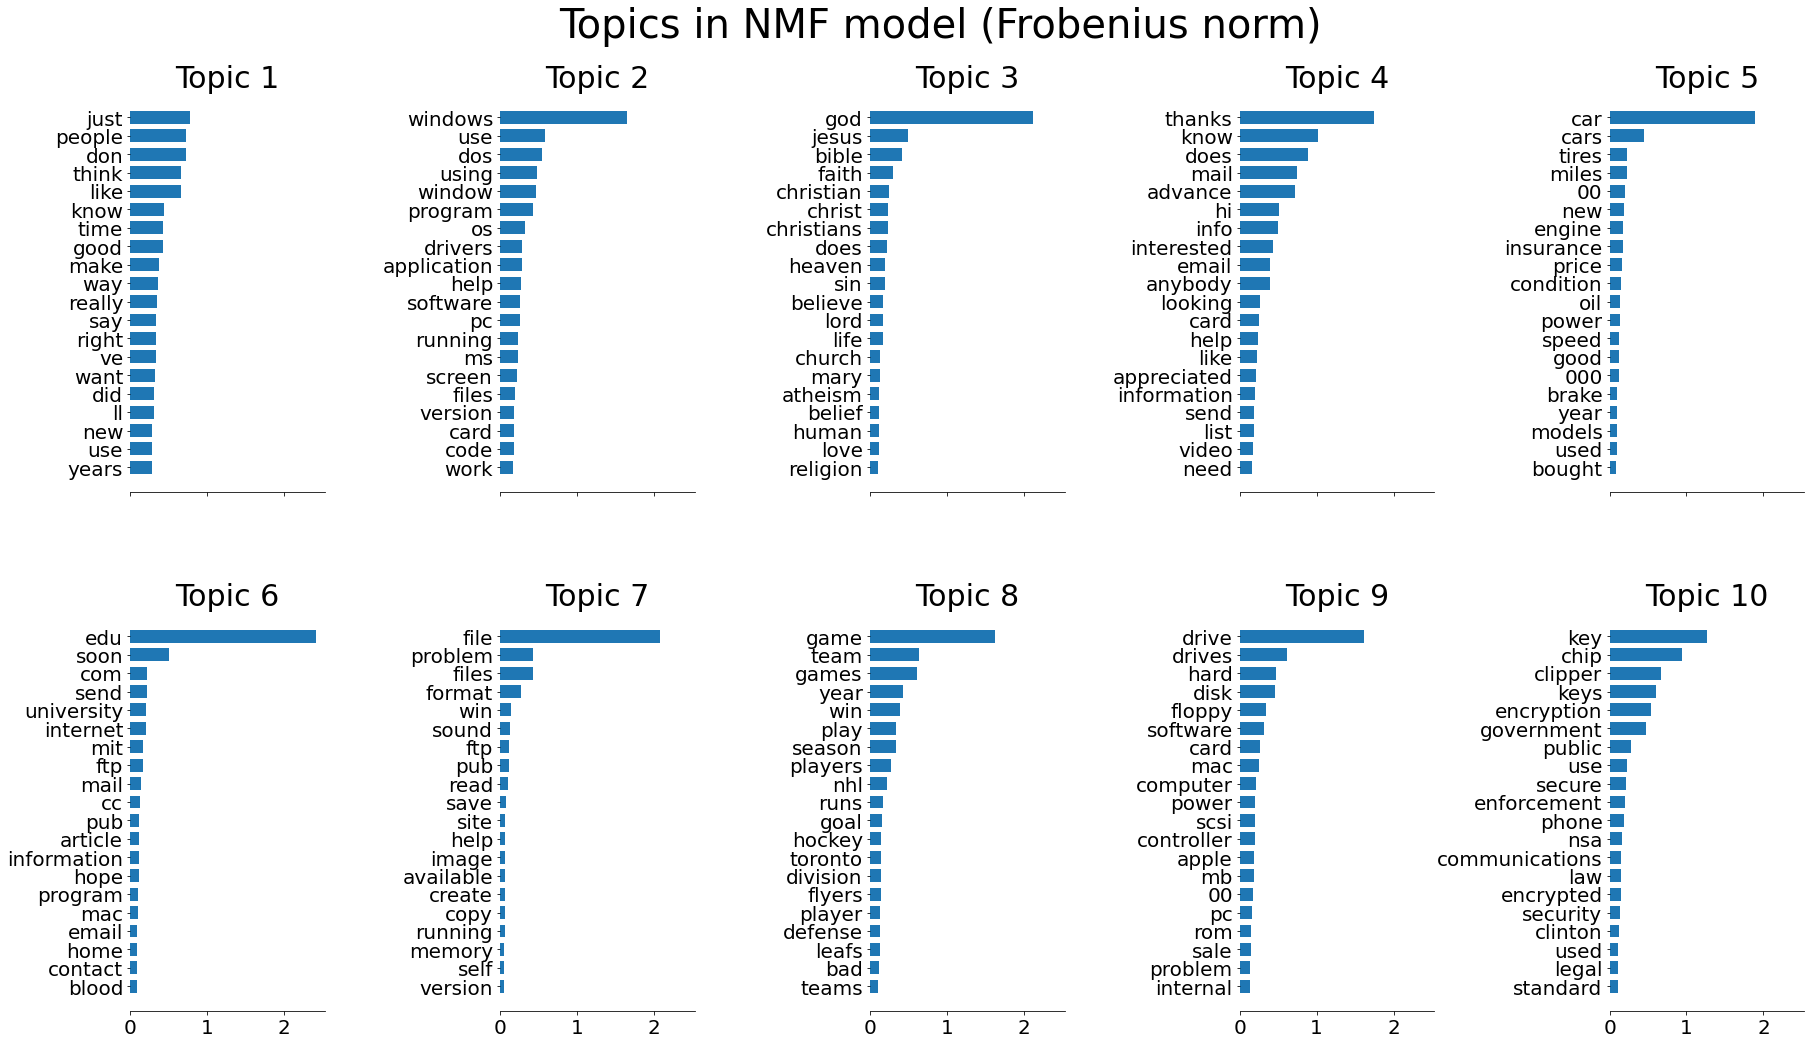



 Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=2000 and n_features=1000...
done in 0.636s.


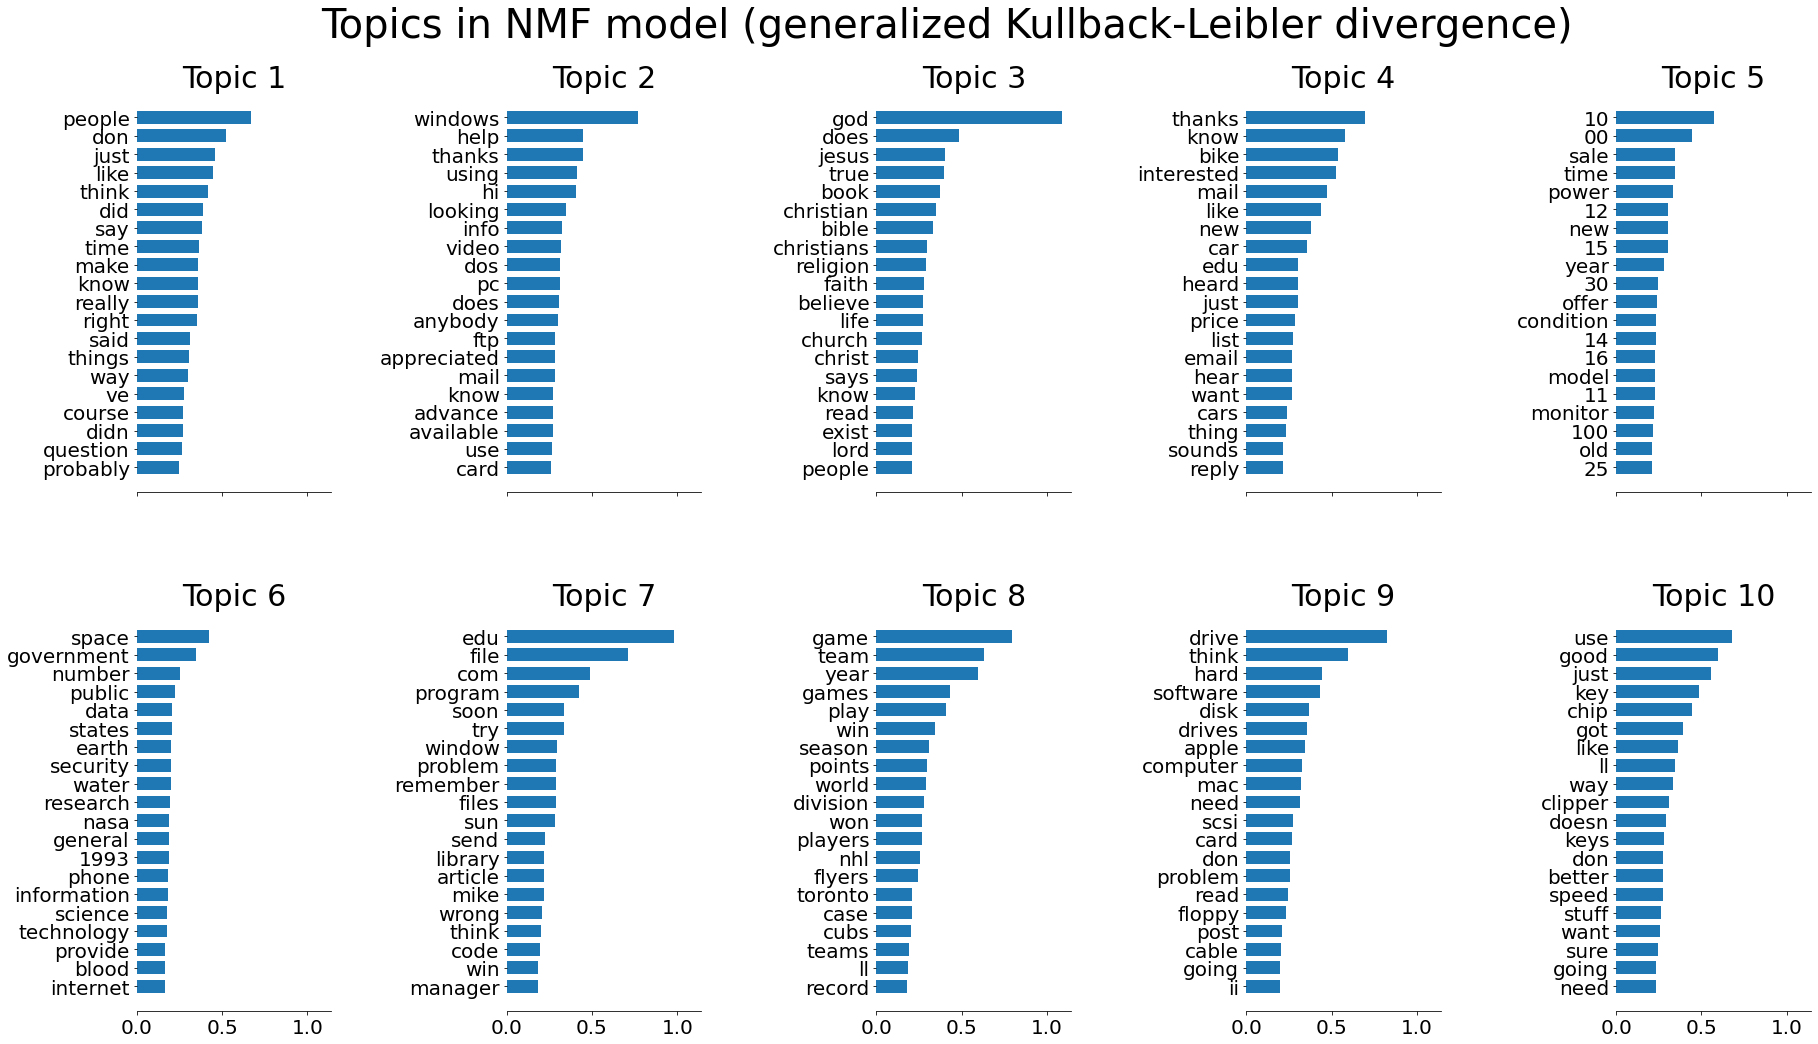



 Fitting LDA models with tf features, n_samples=2000 and n_features=1000...
done in 2.704s.


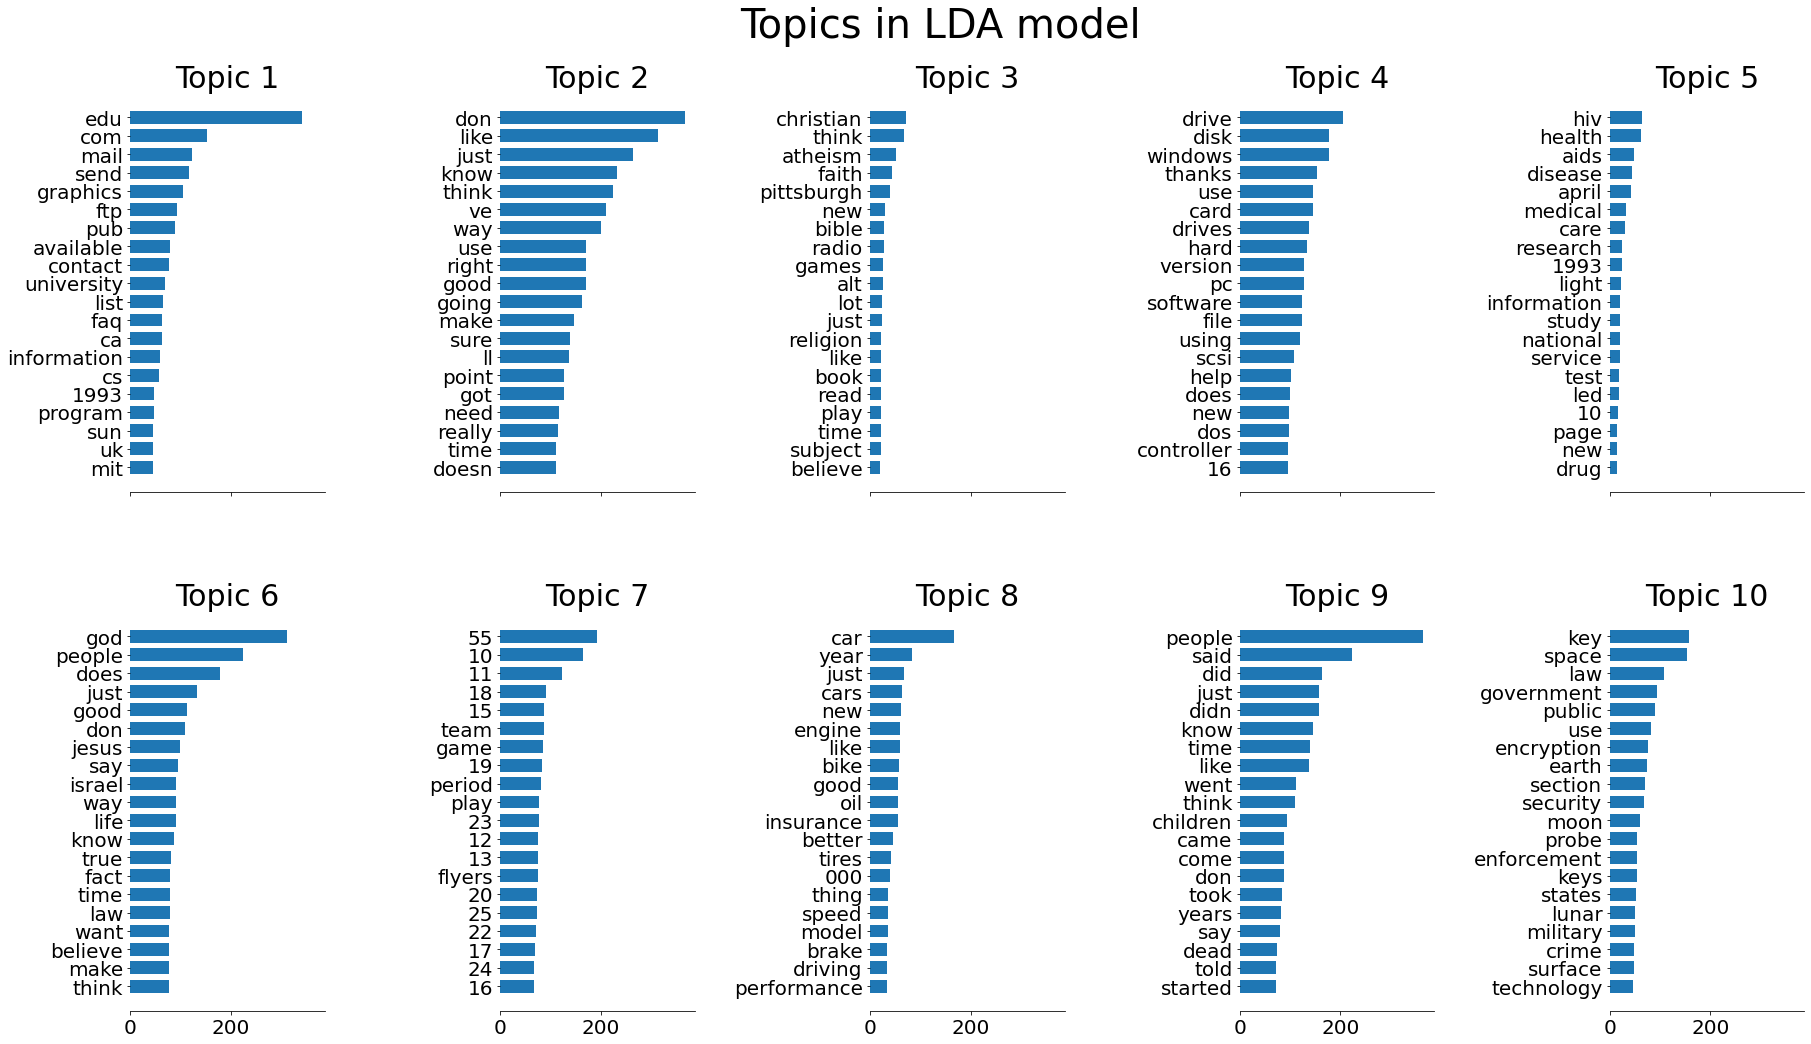

In [32]:
# Author: Olivier Grisel <olivier.grisel@ensta.org>
#         Lars Buitinck
#         Chyi-Kwei Yau <chyikwei.yau@gmail.com>
# License: BSD 3 clause

from time import time
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.datasets import fetch_20newsgroups

n_samples = 2000
n_features = 1000
n_components = 10
n_top_words = 20


def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()


# Load the 20 newsgroups dataset and vectorize it. We use a few heuristics
# to filter out useless terms early on: the posts are stripped of headers,
# footers and quoted replies, and common English words, words occurring in
# only one document or in at least 95% of the documents are removed.

print("Loading dataset...")
t0 = time()
data, _ = fetch_20newsgroups(shuffle=True, random_state=1,
                             remove=('headers', 'footers', 'quotes'),
                             return_X_y=True)
data_samples = data[:n_samples]
print("done in %0.3fs." % (time() - t0))

# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))

# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=n_features,
                                stop_words='english')
t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))
print()

# Fit the NMF model
print("Fitting the NMF model (Frobenius norm) with tf-idf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))


tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_top_words(nmf, tfidf_feature_names, n_top_words,
               'Topics in NMF model (Frobenius norm)')

# Fit the NMF model
print('\n' * 2, "Fitting the NMF model (generalized Kullback-Leibler "
      "divergence) with tf-idf features, n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
          l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_top_words(nmf, tfidf_feature_names, n_top_words,
               'Topics in NMF model (generalized Kullback-Leibler divergence)')

print('\n' * 2, "Fitting LDA models with tf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))

tf_feature_names = tf_vectorizer.get_feature_names()
plot_top_words(lda, tf_feature_names, n_top_words, 'Topics in LDA model')